In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [3]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

Processando a categoria: 'Benign'
  -> Treino: 1118865 | Teste: 559433 | Validação: 559433
Processando a categoria: 'Fuzzers'
  -> Treino: 16908 | Teste: 8454 | Validação: 8454
Processando a categoria: 'Exploits'
  -> Treino: 21374 | Teste: 10687 | Validação: 10687
Processando a categoria: 'Backdoor'
  -> Treino: 2329 | Teste: 1165 | Validação: 1165
Processando a categoria: 'Reconnaissance'
  -> Treino: 8537 | Teste: 4268 | Validação: 4269
Processando a categoria: 'Generic'
  -> Treino: 9825 | Teste: 4913 | Validação: 4913
Processando a categoria: 'DoS'
  -> Treino: 2990 | Teste: 1495 | Validação: 1495
Processando a categoria: 'Shellcode'
  -> Treino: 1190 | Teste: 595 | Validação: 596
Processando a categoria: 'Analysis'
  -> Treino: 613 | Teste: 306 | Validação: 307
Processando a categoria: 'Worms'
  -> Treino: 79 | Teste: 39 | Validação: 40

--- Base de Treino ---
Tamanho: 1182710 linhas
Categorias presentes: ['Benign' 'Exploits' 'Reconnaissance' 'Fuzzers' 'DoS' 'Generic' 'Backdoor'


In [4]:
df_BOT = creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

Processando a categoria: 'Benign'
  -> Treino: 25994 | Teste: 12997 | Validação: 12998
Processando a categoria: 'DDoS'
  -> Treino: 3575441 | Teste: 1787720 | Validação: 1787721
Processando a categoria: 'DoS'
  -> Treino: 4017095 | Teste: 2008547 | Validação: 2008548
Processando a categoria: 'Reconnaissance'
  -> Treino: 847566 | Teste: 423783 | Validação: 423783
Processando a categoria: 'Theft'
  -> Treino: 807 | Teste: 404 | Validação: 404

--- Base de Treino ---
Tamanho: 8466903 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               4017095
DDoS              3575441
Reconnaissance     847566
Benign              25994
Theft                 807
Name: count, dtype: int64
-------------------------

--- Base de Teste ---
Tamanho: 4233451 linhas
Categorias presentes: ['DDoS' 'DoS' 'Reconnaissance' 'Benign' 'Theft']
Attack
DoS               2008547
DDoS              1787720
Reconnaissance     423783
Benign              12997
Theft            

In [5]:
df_CIC = creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

Processando a categoria: 'Benign'
  -> Treino: 8757313 | Teste: 4378656 | Validação: 4378657
Processando a categoria: 'FTP-BruteForce'
  -> Treino: 193360 | Teste: 96680 | Validação: 96680
Processando a categoria: 'SSH-Bruteforce'
  -> Treino: 94237 | Teste: 47118 | Validação: 47119
Processando a categoria: 'DoS_attacks-GoldenEye'
  -> Treino: 30650 | Teste: 15325 | Validação: 15325
Processando a categoria: 'DoS_attacks-Slowloris'
  -> Treino: 18020 | Teste: 9010 | Validação: 9010
Processando a categoria: 'DoS_attacks-SlowHTTPTest'
  -> Treino: 52775 | Teste: 26387 | Validação: 26388
Processando a categoria: 'DoS_attacks-Hulk'
  -> Treino: 50038 | Teste: 25019 | Validação: 25019
Processando a categoria: 'DDoS_attacks-LOIC-HTTP'
  -> Treino: 144294 | Teste: 72147 | Validação: 72148
Processando a categoria: 'DDOS_attack-LOIC-UDP'
  -> Treino: 1725 | Teste: 862 | Validação: 863
Processando a categoria: 'DDOS_attack-HOIC'
  -> Treino: 516155 | Teste: 258078 | Validação: 258078
Processando 

In [6]:
model_names = ['UNSW_EA', 'BOT_EA', 'CIC_EA']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

ERROR! Session/line number was not unique in database. History logging moved to new session 227


In [23]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=5)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [24]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_time = time.perf_counter()

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            branch_conf, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = branch_conf > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.perf_counter()
    
    total_inference_time = end_time - start_time

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = correct / total_samples
    exit_rate = exited_early_count / total_samples
    
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'total_inference_time_sec': total_inference_time
        }

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6895, Validation Loss: 0.6826
Epoch [2/500], Train Loss: 0.6773, Validation Loss: 0.6697
Epoch [3/500], Train Loss: 0.6623, Validation Loss: 0.6529
Epoch [4/500], Train Loss: 0.6426, Validation Loss: 0.6345
Epoch [5/500], Train Loss: 0.6239, Validation Loss: 0.6181
Epoch [6/500], Train Loss: 0.6078, Validation Loss: 0.6015
Epoch [7/500], Train Loss: 0.5919, Validation Loss: 0.5821
Epoch [8/500], Train Loss: 0.5738, Validation Loss: 0.5610
Epoch [9/500], Train Loss: 0.5529, Validation Loss: 0.5362
Epoch [10/500], Train Loss: 0.5309, Validation Loss: 0.5088
Epoch [11/500], Train Loss: 0.5091, Validation Loss: 0.4818
Epoch [12/500], Train Loss: 0.4853, Validation Loss: 0.4569
Epoch [13/500], Train Loss: 0.4647, Validation Loss: 0.4329
Epoch [14/500], Train Loss: 0.4406, Validation Loss: 0.4103
Epoch [15/500], Train Loss: 0.4230, Validation Loss: 0.3902
Epoch [16/500], Train Loss: 0.4037, Validati

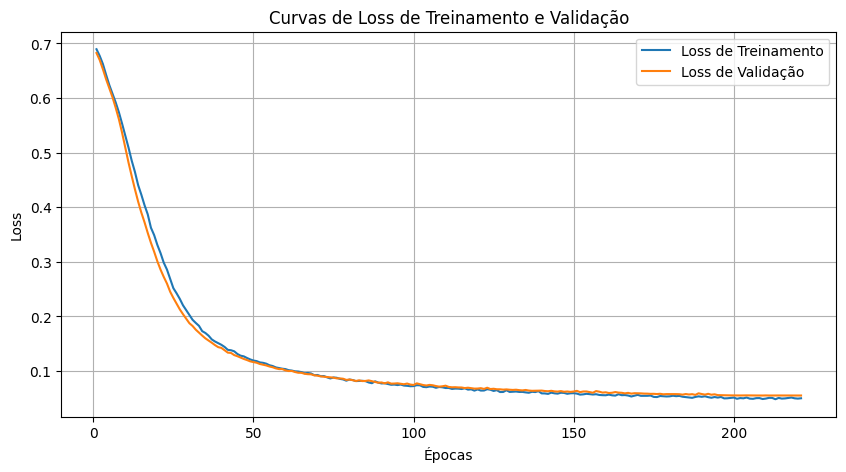

Model saved at 'models/UNSW_EA_1.pth'

--- Training model: UNSW_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6791, Validation Loss: 0.6416
Epoch [2/500], Train Loss: 0.6387, Validation Loss: 0.6269
Epoch [3/500], Train Loss: 0.6184, Validation Loss: 0.6079
Epoch [4/500], Train Loss: 0.5957, Validation Loss: 0.5634
Epoch [5/500], Train Loss: 0.5637, Validation Loss: 0.4980
Epoch [6/500], Train Loss: 0.5384, Validation Loss: 0.5126
Epoch [7/500], Train Loss: 0.4950, Validation Loss: 0.4477
Epoch [8/500], Train Loss: 0.4550, Validation Loss: 0.4001
Epoch [9/500], Train Loss: 0.4240, Validation Loss: 0.3497
Epoch [10/500], Train Loss: 0.3978, Validation Loss: 0.3202
Epoch [11/500], Train Loss: 0.3648, Validation Loss: 0.3175
Epoch [12/500], Train Loss: 0.3440, Validation Loss: 0.2794
Epoch [13/500], Train Loss: 0.3161, Validation Loss: 0.2613
Epoch [14/500], Train Loss: 0.3000, Validation Loss: 0.3299
Epoch [15/500], Train Loss: 0.2786, Validation Loss: 0.2205
Epoch

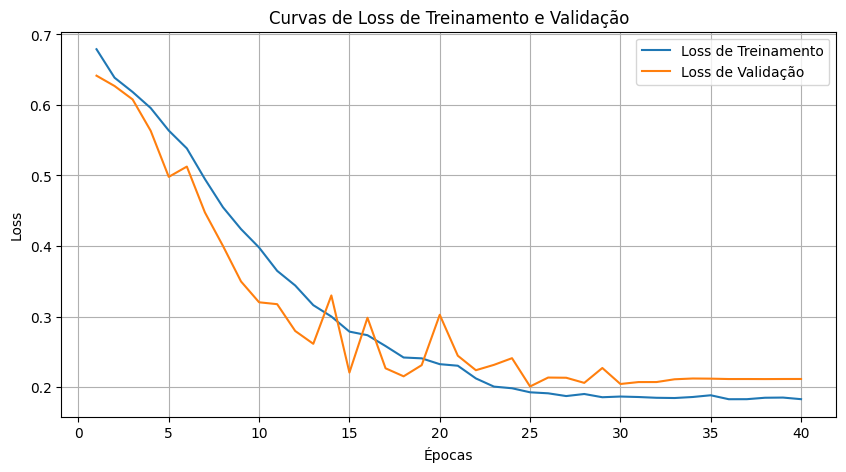

Model saved at 'models/UNSW_EA_2.pth'

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3850, Validation Loss: 1.3613
Epoch [2/500], Train Loss: 1.3395, Validation Loss: 1.3107
Epoch [3/500], Train Loss: 1.2962, Validation Loss: 1.2811
Epoch [4/500], Train Loss: 1.2660, Validation Loss: 1.2298
Epoch [5/500], Train Loss: 1.2211, Validation Loss: 1.1799
Epoch [6/500], Train Loss: 1.1787, Validation Loss: 1.1097
Epoch [7/500], Train Loss: 1.1301, Validation Loss: 1.0473
Epoch [8/500], Train Loss: 1.0810, Validation Loss: 1.0029
Epoch [9/500], Train Loss: 1.0417, Validation Loss: 0.9524
Epoch [10/500], Train Loss: 0.9954, Validation Loss: 0.8993
Epoch [11/500], Train Loss: 0.9596, Validation Loss: 0.8576
Epoch [12/500], Train Loss: 0.9126, Validation Loss: 0.8285
Epoch [13/500], Train Loss: 0.8748, Validation Loss: 0.7928
Epoch [14/500], Train Loss: 0.8370, Validation Loss: 0.7490
Epoch [15/500], Train Loss: 0.7950, Validation Loss: 0.7204
Epoch

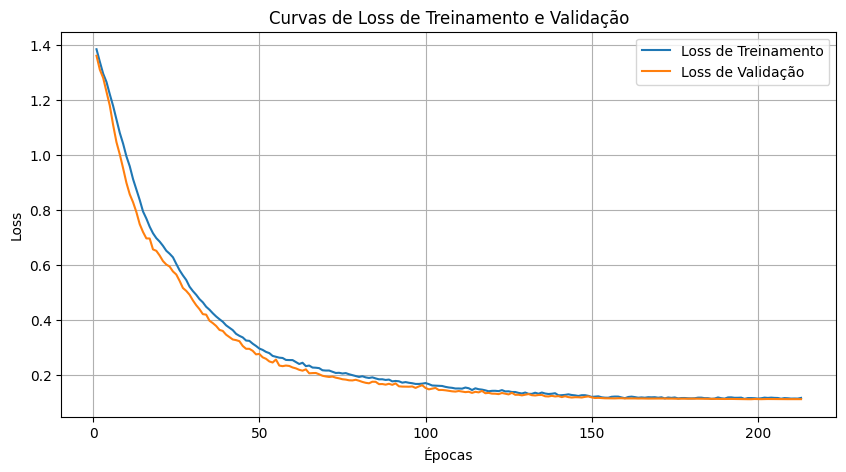

Model saved at 'models/UNSW_EA_3.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6938, Validation Loss: 0.6919
Epoch [2/500], Train Loss: 0.6911, Validation Loss: 0.6885
Epoch [3/500], Train Loss: 0.6878, Validation Loss: 0.6847
Epoch [4/500], Train Loss: 0.6842, Validation Loss: 0.6804
Epoch [5/500], Train Loss: 0.6799, Validation Loss: 0.6751
Epoch [6/500], Train Loss: 0.6736, Validation Loss: 0.6683
Epoch [7/500], Train Loss: 0.6669, Validation Loss: 0.6601
Epoch [8/500], Train Loss: 0.6585, Validation Loss: 0.6503
Epoch [9/500], Train Loss: 0.6481, Validation Loss: 0.6385
Epoch [10/500], Train Loss: 0.6369, Validation Loss: 0.6251
Epoch [11/500], Train Loss: 0.6241, Validation Loss: 0.6103
Epoch [12/500], Train Loss: 0.6097, Validation Loss: 0.5947
Epoch [13/500], Train Loss: 0.5943, Validation Loss: 0.5789
Epoch [14/500], Train Loss: 0.5789, Validation Loss: 0.5630
Epoch [15/500], Train Loss: 0.5639, Validation Loss: 0.5475
Epoch 

KeyboardInterrupt: 

In [25]:
epochs = 500

for model_id in range(len(model_names)):
    for test in test_ids:
        model = IDSBranchyNet()
        
        if test == 1:
            weight1 = 1
            weight2 = 0
        elif test == 2:
            weight1 = 0
            weight2 = 1
        elif test == 3:
            weight1 = 1
            weight2 = 1
        
            
        print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
        
        train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device)

        torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
        print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
        

In [ ]:
for model_id in range(len(model_names)):
    for loader in range(len(test_loaders)):
        for test in test_ids:
    
            print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")
    
            model.load_state_dict(torch.load(f'models/{model_names[model_id]}_{test}.pth'))
            model.to(device)
            model.eval()
            print(f"Model from: 'models/{model_names[model_id]}_{test}.pth' carregado")

            if test == 1:
                t=0
            elif test == 2:
                t=2
            elif test == 3:
                t=0.99
    
            results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
            
            print("-" * 20)
            print(f"Threshold: {t:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
            print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
            print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
            print("-" * 20)
            print("\n")